# Prep

In [5]:

import numpy as np
import pandas as pd
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch

import matplotlib.pyplot as plt
import supervision as sv 
from scipy.spatial.distance import cdist
import os
import cv2

from scipy.spatial.distance import cdist

In [2]:
!nvidia-smi

Wed Mar  5 09:24:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:41:00.0 Off |                  Off |
| 30%   32C    P8             22W /  300W |       2MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch

# Step 1: Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    
    # Step 2: Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    
    # Step 3: Print details about each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    # Step 4: Check the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device} ({torch.cuda.get_device_name(current_device)})")
else:
    print("CUDA is not available. Make sure you have a GPU and the correct drivers installed.")

CUDA is available!
Number of available GPUs: 1
GPU 0: NVIDIA RTX A6000
Current CUDA device: 0 (NVIDIA RTX A6000)


# SAM2 in action

In [4]:


# Set up paths and device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HOME = "/home/adonyi/NanoLive/segment-anything-2" # leave like that because of the yalm ----------------------------------------------
VIDEO_PATH = "/home/adonyi/NanoLive/test_video_neg.avi"
OUTPUT_DIR = "/home/adonyi/NanoLive/finetuned_results/negative"
OBJECTS_DIR = os.path.join(OUTPUT_DIR, "segmented_objects")
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

# Ensure output directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OBJECTS_DIR, exist_ok=True)

# Load SAM model
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

# Set up mask generator with original parameters
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

def get_refined_edge_coordinates(mask):
    """
    Extract and refine edge coordinates from a binary mask.
    Returns sorted edge coordinates that follow the object boundary.
    """
    # Get contours with improved parameters
    contours, _ = cv2.findContours(mask.astype(np.uint8), 
                                 cv2.RETR_EXTERNAL,
                                 cv2.CHAIN_APPROX_TC89_KCOS)
    
    if not contours:
        return []
    
    # Get the largest contour (main object boundary)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Apply contour approximation to reduce noise
    epsilon = 0.001 * cv2.arcLength(largest_contour, True)
    approx_contour = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Convert to list of tuples
    edge_coordinates = [(x[0][0], x[0][1]) for x in approx_contour]
    
    # Sort points to ensure they follow the contour
    if edge_coordinates:
        center = np.mean(edge_coordinates, axis=0)
        edge_coordinates.sort(key=lambda p: np.arctan2(p[1] - center[1], 
                                                     p[0] - center[0]))
    
    return edge_coordinates

def assign_object_ids(previous_objects, current_objects, max_distance=50):
    """
    Assign consistent object IDs across frames based on centroid positions.
    """
    if not previous_objects:
        return [i for i in range(len(current_objects))]
    
    prev_centroids = np.array([(obj['centroid_x'], obj['centroid_y']) for obj in previous_objects])
    curr_centroids = np.array([(obj['centroid_x'], obj['centroid_y']) for obj in current_objects])
    
    distances = cdist(prev_centroids, curr_centroids)
    
    assigned_ids = [-1] * len(current_objects)
    used_prev_ids = set()
    
    for curr_idx in range(len(current_objects)):
        prev_idx = np.argmin(distances[:, curr_idx])
        if distances[prev_idx, curr_idx] <= max_distance:
            assigned_ids[curr_idx] = previous_objects[prev_idx]['object_id']
            used_prev_ids.add(previous_objects[prev_idx]['object_id'])
    
    next_new_id = max([obj['object_id'] for obj in previous_objects], default=-1) + 1
    for i in range(len(assigned_ids)):
        if assigned_ids[i] == -1:
            while next_new_id in used_prev_ids:
                next_new_id += 1
            assigned_ids[i] = next_new_id
            next_new_id += 1
    
    return assigned_ids

# Open the video file
cap = cv2.VideoCapture(VIDEO_PATH)

# Get video properties for progress tracking
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Video has {total_frames} frames at {fps} FPS")

# Initialize list to store all frame data
all_frame_data = []
previous_objects = []

# Process all frames in the video
frame_number = 0
while True:
    ret, frame = cap.read()
    if not ret:  # Check if the frame was successfully read
        print(f"Finished processing at frame {frame_number} of {total_frames}")
        break
    
    print(f"Processing frame {frame_number} of {total_frames} ({(frame_number/total_frames*100):.1f}%)")
    
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Generate masks
    sam2_result = mask_generator.generate(frame_rgb)
    
    # Extract information for each detected object
    frame_data = []
    for i, mask_data in enumerate(sam2_result):
        mask = mask_data['segmentation']
        bbox = mask_data['bbox']
        area = mask_data['area']
        
        # Calculate centroid
        y, x = np.where(mask)
        if len(y) == 0 or len(x) == 0:
            continue  # Skip if mask is empty
            
        centroid_x, centroid_y = np.mean(x), np.mean(y)
        
        # Calculate average brightness in the masked area
        brightness = np.mean(frame_rgb[mask])
        
        # Get refined edge coordinates
        edge_coordinates = get_refined_edge_coordinates(mask)
        
        # Extract the object using the mask
        object_image = np.zeros(frame.shape, dtype=np.uint8)
        object_image[mask] = frame[mask]
        
        # Crop the object image to remove unnecessary background
        x, y, w, h = cv2.boundingRect(mask.astype(np.uint8))
        object_image_cropped = object_image[y:y+h, x:x+w]
        
        # Create a new mask for the cropped image
        mask_cropped = mask[y:y+h, x:x+w]
        
        # Create a transparent background
        object_image_rgba = cv2.cvtColor(object_image_cropped, cv2.COLOR_BGR2BGRA)
        object_image_rgba[:, :, 3] = mask_cropped.astype(np.uint8) * 255
        
        # Store data (without saving the image yet)
        frame_data.append({
            'frame': frame_number,
            'area': area,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'bbox_x': x,
            'bbox_y': y,
            'bbox_width': w,
            'bbox_height': h,
            'brightness': brightness,
            'edge_coordinates': edge_coordinates,
            'object_image': object_image_rgba
        })
    
    # Assign object IDs
    object_ids = assign_object_ids(previous_objects, frame_data)
    
    # Update frame_data with object IDs and save images
    for i, obj_data in enumerate(frame_data):
        obj_data['object_id'] = object_ids[i]
        
        # Save the object image with transparent background
        object_filename = f"object_{obj_data['object_id']}_frame_{frame_number}.png"
        object_path = os.path.join(OBJECTS_DIR, object_filename)
        cv2.imwrite(object_path, obj_data['object_image'])
        
        # Update the object_image_path and remove the actual image data
        obj_data['object_image_path'] = object_path
        del obj_data['object_image']
    
    # Append the current frame's data to the overall list
    all_frame_data.extend(frame_data)
    previous_objects = frame_data
    
    # Save progress periodically (every 10 frames)
    if frame_number % 10 == 0 and frame_number > 0:
        temp_df = pd.DataFrame(all_frame_data)
        temp_df['edge_coordinates'] = temp_df['edge_coordinates'].apply(str)
        temp_csv = os.path.join(OUTPUT_DIR, f"progress_up_to_frame_{frame_number}.csv")
        temp_df.to_csv(temp_csv, index=False)
        print(f"Progress saved up to frame {frame_number}")
    
    frame_number += 1

# Release the video capture object
cap.release()

# Convert all data to a DataFrame
df = pd.DataFrame(all_frame_data)

# Handle empty DataFrame case
if not df.empty:
    # Convert the 'edge_coordinates' column from lists to strings to be able to save them in a CSV file
    df['edge_coordinates'] = df['edge_coordinates'].apply(str)
    
    # Save the DataFrame to a CSV file
    output_csv = os.path.join(OUTPUT_DIR, "negative_finetuned.csv")
    df.to_csv(output_csv, index=False)
    print(f"Data saved to {output_csv}")
    print(f"Segmented objects saved to {OBJECTS_DIR}")
else:
    print("No objects detected. No data to save.")

print("Processing complete!")

Video has 200 frames at 10.0 FPS
Processing frame 0 of 200 (0.0%)


Falling back to all available kernels for scaled_dot_product_attention (which may have a slower speed).


Processing frame 1 of 200 (0.5%)
Processing frame 2 of 200 (1.0%)
Processing frame 3 of 200 (1.5%)
Processing frame 4 of 200 (2.0%)
Processing frame 5 of 200 (2.5%)
Processing frame 6 of 200 (3.0%)
Processing frame 7 of 200 (3.5%)
Processing frame 8 of 200 (4.0%)
Processing frame 9 of 200 (4.5%)
Processing frame 10 of 200 (5.0%)
Progress saved up to frame 10
Processing frame 11 of 200 (5.5%)
Processing frame 12 of 200 (6.0%)
Processing frame 13 of 200 (6.5%)
Processing frame 14 of 200 (7.0%)
Processing frame 15 of 200 (7.5%)
Processing frame 16 of 200 (8.0%)
Processing frame 17 of 200 (8.5%)
Processing frame 18 of 200 (9.0%)
Processing frame 19 of 200 (9.5%)
Processing frame 20 of 200 (10.0%)
Progress saved up to frame 20
Processing frame 21 of 200 (10.5%)
Processing frame 22 of 200 (11.0%)
Processing frame 23 of 200 (11.5%)
Processing frame 24 of 200 (12.0%)
Processing frame 25 of 200 (12.5%)
Processing frame 26 of 200 (13.0%)
Processing frame 27 of 200 (13.5%)
Processing frame 28 of 

## QC

In [5]:
objects = "/home/adonyi/NanoLive/finetuned_results/positive/segmented_objects"
csv = "/home/adonyi/NanoLive/finetuned_results/negative/negative_finetuned.csv"

In [6]:
df = pd.read_csv(csv)
df

frame   area   centroid_x   centroid_y  bbox_x  bbox_y  bbox_width  \
0           0  11589   592.892743   181.065321     520     127         138   
1           0   7633  1270.141753  1221.186689    1226    1163          89   
2           0   1855    38.978437    10.847978       0       0          89   
3           0  12916   782.387581  1203.596547     706    1153         157   
4           0   1141   917.262927   103.403155     899      85          38   
...       ...    ...          ...          ...     ...     ...         ...   
150565    199  13207  1222.406300  1796.760733    1149    1381         144   
150566    199   1345   715.606691   842.454275     693     824          51   
150567    199  26428  1233.087899  1496.240124    1152    1369         152   
150568    199   3270   667.562080    24.103364     627       0          81   
150569    199  19749   895.379614  1076.451010     825     983         128   

        bbox_height  brightness  \
0               112   61.478212   
1               114   94.270012   
2                26  121.646361   
3               103   53.259368   
4                39  182.485539   
...             ...         ...   
150565          491   78.785568   
150566           40  158.835688   
150567          246   67.727827   
150568           60   37.394190   
150569          198   41.068409   

                                         edge_coordinates  object_id  \
0       [(522, 176), (520, 168), (520, 160), (521, 156...          0   
1       [(1228, 1220), (1232, 1205), (1235, 1198), (12...          1   
2       [(0, 0), (88, 0), (88, 2), (84, 5), (84, 6), (...          2   
3       [(712, 1206), (713, 1200), (715, 1196), (718, ...          3   
4       [(899, 99), (900, 96), (904, 90), (906, 88), (...          4   
...                                                   ...        ...   
150565  [(1157, 1785), (1158, 1780), (1161, 1777), (11...      12623   
150566  [(694, 838), (698, 833), (700, 831), (703, 829...      14816   
150567  [(1169, 1491), (1173, 1485), (1174, 1474), (11...      14434   
150568  [(640, 29), (638, 26), (636, 22), (636, 20), (...      14554   
150569  [(826, 1083), (825, 1055), (828, 1042), (833, ...      13738   

                                        object_image_path  
0       /home/adonyi/NanoLive/finetuned_results/negati...  
1       /home/adonyi/NanoLive/finetuned_results/negati...  
2       /home/adonyi/NanoLive/finetuned_results/negati...  
3       /home/adonyi/NanoLive/finetuned_results/negati...  
4       /home/adonyi/NanoLive/finetuned_results/negati...  
...                                                   ...  
150565  /home/adonyi/NanoLive/finetuned_results/negati...  
150566  /home/adonyi/NanoLive/finetuned_results/negati...  
150567  /home/adonyi/NanoLive/finetuned_results/negati...  
150568  /home/adonyi/NanoLive/finetuned_results/negati...  
150569  /home/adonyi/NanoLive/finetuned_results/negati...  

[150570 rows x 12 columns]

In [12]:
df.columns

Index(['frame', 'area', 'centroid_x', 'centroid_y', 'bbox_x', 'bbox_y',
       'bbox_width', 'bbox_height', 'brightness', 'edge_coordinates',
       'object_id', 'object_image_path'],
      dtype='object')

In [7]:


# Define the path to the folder
folder_path = "/home/adonyi/NanoLive/finetuned_results/negative/segmented_objects"

# Get a list of all files in the folder
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Count the total number of files
total_files = len(files)

print(f"Total number of files: {total_files}")

Total number of files: 70588


# bounding box removal

In [1]:
def create_multi_frame_filtered_csv(csv_path, video_path, size_ratio_threshold=0.5, overlap_threshold=0.7):
    import pandas as pd
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import ast
    
    # Load the full CSV with multiple frames
    df_full = pd.read_csv(csv_path)
    
    # Get all unique frame numbers
    unique_frames = df_full['frame'].unique()
    print(f"Found {len(unique_frames)} unique frames in the CSV file")
    
    # Function to convert edge_coordinates to numpy array for processing
    def parse_edge_coordinates(coords):
        if isinstance(coords, str):
            # Try to parse as a list of tuples
            try:
                return ast.literal_eval(coords)
            except:
                # If that fails, try numpy array conversion but return as list of tuples
                try:
                    np_coords = np.array(eval(coords))
                    return [(int(x), int(y)) for x, y in np_coords]
                except:
                    print(f"Warning: Could not parse coordinates: {coords}")
                    return coords
        return coords
    
    # Function to filter nested red objects only
    def filter_nested_objects(df, size_ratio_threshold, overlap_threshold, min_area=3000, max_area=50000):
        # Make a copy of the dataframe to avoid modifying the original
        df_filtered = df.copy()
        removed_indices = []
        
        # Store original coordinates format
        original_coords = {}
        for idx, row in df_filtered.iterrows():
            original_coords[idx] = row['edge_coordinates']
        
        # Convert edge_coordinates for processing
        df_filtered['edge_coordinates_np'] = df_filtered['edge_coordinates'].apply(
            lambda x: np.array(parse_edge_coordinates(x))
        )
        
        # Create a mask for red objects (the ones we want to filter)
        red_mask = (df_filtered['area'] >= min_area) & (df_filtered['area'] <= max_area)
        
        # Get indices of red objects only
        red_indices = df_filtered[red_mask].index.tolist()
        
        # Sort red objects by area in descending order
        red_objects = df_filtered.loc[red_indices].sort_values('area', ascending=False)
        
        # We'll only compare and filter red objects against other red objects
        for idx1, row1 in red_objects.iterrows():
            if idx1 in removed_indices:
                continue
                
            obj1_area = row1['area']
            obj1_coords = row1['edge_coordinates_np']
            
            # Get bounding box for object 1
            obj1_min_x, obj1_min_y = obj1_coords.min(axis=0)
            obj1_max_x, obj1_max_y = obj1_coords.max(axis=0)
            
            # Only compare with other RED objects
            for idx2 in red_indices:
                if idx2 == idx1 or idx2 in removed_indices:
                    continue
                    
                row2 = df_filtered.loc[idx2]
                obj2_area = row2['area']
                obj2_coords = row2['edge_coordinates_np']
                
                # Size ratio check
                size_ratio = obj2_area / obj1_area
                
                if size_ratio < size_ratio_threshold:
                    # Get bounding box for object 2
                    obj2_min_x, obj2_min_y = obj2_coords.min(axis=0)
                    obj2_max_x, obj2_max_y = obj2_coords.max(axis=0)
                    
                    # Calculate overlap area
                    overlap_width = max(0, min(obj1_max_x, obj2_max_x) - max(obj1_min_x, obj2_min_x))
                    overlap_height = max(0, min(obj1_max_y, obj2_max_y) - max(obj1_min_y, obj2_min_y))
                    overlap_area = overlap_width * overlap_height
                    
                    # Calculate bounding box areas
                    bbox2_area = (obj2_max_x - obj2_min_x) * (obj2_max_y - obj2_min_y)
                    
                    # Calculate overlap ratio
                    if bbox2_area > 0:
                        overlap_ratio = overlap_area / bbox2_area
                    else:
                        overlap_ratio = 0
                    
                    if overlap_ratio > overlap_threshold:
                        removed_indices.append(idx2)
        
        # Create DataFrame of removed objects (only from red objects)
        removed_df = df_filtered.loc[removed_indices].copy()
        
        # Create filtered DataFrame without removed objects
        df_filtered = df_filtered.drop(removed_indices).reset_index(drop=True)
        
        # Drop the numpy array column used for calculations
        df_filtered = df_filtered.drop(columns=['edge_coordinates_np'])
        if not removed_df.empty:
            removed_df = removed_df.drop(columns=['edge_coordinates_np'])
        
        return df_filtered, removed_df
    
    # Process each frame and collect filtered results
    all_filtered_dfs = []
    all_removed_dfs = []
    total_objects_before = 0
    total_objects_after = 0
    total_red_objects_before = 0
    total_red_objects_after = 0
    total_objects_removed = 0
    
    for frame_num in unique_frames:
        # Extract data for this frame
        df_frame = df_full[df_full['frame'] == frame_num].copy()
        total_objects_before += len(df_frame)
        
        # Count red objects before filtering
        red_mask = (df_frame['area'] >= 3000) & (df_frame['area'] <= 50000)
        red_count_before = len(df_frame[red_mask])
        total_red_objects_before += red_count_before
        
        # Apply the filtering
        df_filtered, removed_df = filter_nested_objects(df_frame, size_ratio_threshold, overlap_threshold)
        total_objects_after += len(df_filtered)
        total_objects_removed += len(removed_df)
        
        # Count red objects after filtering
        red_mask = (df_filtered['area'] >= 3000) & (df_filtered['area'] <= 50000)
        red_count_after = len(df_filtered[red_mask])
        total_red_objects_after += red_count_after
        
        # Add to our collection of filtered data
        all_filtered_dfs.append(df_filtered)
        all_removed_dfs.append(removed_df)
        
        print(f"Frame {frame_num}: Filtered {len(removed_df)} red objects, keeping {red_count_after} red objects and {len(df_filtered) - red_count_after} blue objects")
    
    # Combine all filtered frames into one CSV
    combined_filtered_df = pd.concat(all_filtered_dfs)
    combined_removed_df = pd.concat(all_removed_dfs) if all_removed_dfs and not all(df.empty for df in all_removed_dfs) else None
    
    # Save the combined filtered data
    output_dir = os.path.dirname(csv_path)
    base_filename = os.path.basename(csv_path).replace(".csv", "")
    combined_output_csv = os.path.join(output_dir, f"{base_filename}_filtered.csv")
    combined_filtered_df.to_csv(combined_output_csv, index=False)
    
    # Save the removed objects if there are any
    if combined_removed_df is not None and not combined_removed_df.empty:
        removed_output_csv = os.path.join(output_dir, f"{base_filename}_removed.csv")
        combined_removed_df.to_csv(removed_output_csv, index=False)
        print(f"- Removed objects saved to: {removed_output_csv}")
    
    print(f"\nFiltering complete:")
    print(f"- Total objects before filtering: {total_objects_before}")
    print(f"- Total red objects before filtering: {total_red_objects_before}")
    print(f"- Total objects after filtering: {total_objects_after}")
    print(f"- Total red objects after filtering: {total_red_objects_after}")
    print(f"- Total objects removed: {total_objects_removed}")
    print(f"- Filtered CSV saved to: {combined_output_csv}")
    
    # Visualize the first frame for demonstration
    if len(unique_frames) > 0:
        first_frame_num = unique_frames[0]
        df_first_frame = df_full[df_full['frame'] == first_frame_num].copy()
        df_first_filtered = all_filtered_dfs[0]  # The filtered data for the first frame
        df_first_removed = all_removed_dfs[0] if all_removed_dfs and not all_removed_dfs[0].empty else None
        
        # Read the first frame from video
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, first_frame_num)
        ret, video_frame = cap.read()
        cap.release()
        
        if not ret:
            print("Warning: Could not read the video frame for visualization")
            return combined_output_csv
        
        # Convert BGR to RGB
        video_frame = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)
        
        # Create figure with three subplots: original, before filtering, after filtering
        subplot_count = 4 if df_first_removed is not None and not df_first_removed.empty else 3
        fig, axes = plt.subplots(1, subplot_count, figsize=(8 * subplot_count, 10))
        
        # Plot original video frame
        axes[0].imshow(video_frame)
        axes[0].set_title(f'Original Video Frame (Frame {first_frame_num})')
        axes[0].axis('off')
        
        # Plot before filtering
        blurred_frame = cv2.GaussianBlur(video_frame, (15, 15), 0)
        axes[1].imshow(blurred_frame, alpha=0.3)
        
        def plot_edges(ax, df, title=""):
            for _, row in df.iterrows():
                coords = np.array(parse_edge_coordinates(row['edge_coordinates']))
                area = row['area']
                color = 'red' if 3000 <= area <= 50000 else 'blue'
                ax.plot(coords[:, 0], coords[:, 1], c=color, linewidth=1, alpha=0.8)
            ax.set_title(title)
            ax.axis('off')
        
        plot_edges(axes[1], df_first_frame, f"Before Filtering (Frame {first_frame_num})")
        
        # Plot after filtering
        axes[2].imshow(blurred_frame, alpha=0.3)
        plot_edges(axes[2], df_first_filtered, f"After Filtering (Frame {first_frame_num})")
        
        # Plot removed objects if any
        if df_first_removed is not None and not df_first_removed.empty:
            axes[3].imshow(blurred_frame, alpha=0.3)
            plot_edges(axes[3], df_first_removed, f"Removed Objects (Frame {first_frame_num})")
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{base_filename}_filtering_visualization.png"), dpi=300)
        plt.show()
    
    return combined_output_csv




Found 200 unique frames in the CSV file
Frame 0: Filtered 45 red objects, keeping 154 red objects and 359 blue objects
Frame 1: Filtered 35 red objects, keeping 162 red objects and 377 blue objects
Frame 2: Filtered 41 red objects, keeping 152 red objects and 360 blue objects
Frame 3: Filtered 44 red objects, keeping 160 red objects and 359 blue objects
Frame 4: Filtered 40 red objects, keeping 170 red objects and 353 blue objects
Frame 5: Filtered 42 red objects, keeping 144 red objects and 353 blue objects
Frame 6: Filtered 34 red objects, keeping 164 red objects and 386 blue objects
Frame 7: Filtered 30 red objects, keeping 164 red objects and 390 blue objects
Frame 8: Filtered 33 red objects, keeping 157 red objects and 382 blue objects
Frame 9: Filtered 42 red objects, keeping 151 red objects and 393 blue objects
Frame 10: Filtered 46 red objects, keeping 151 red objects and 373 blue objects
Frame 11: Filtered 40 red objects, keeping 158 red objects and 382 blue objects
Frame 12: 

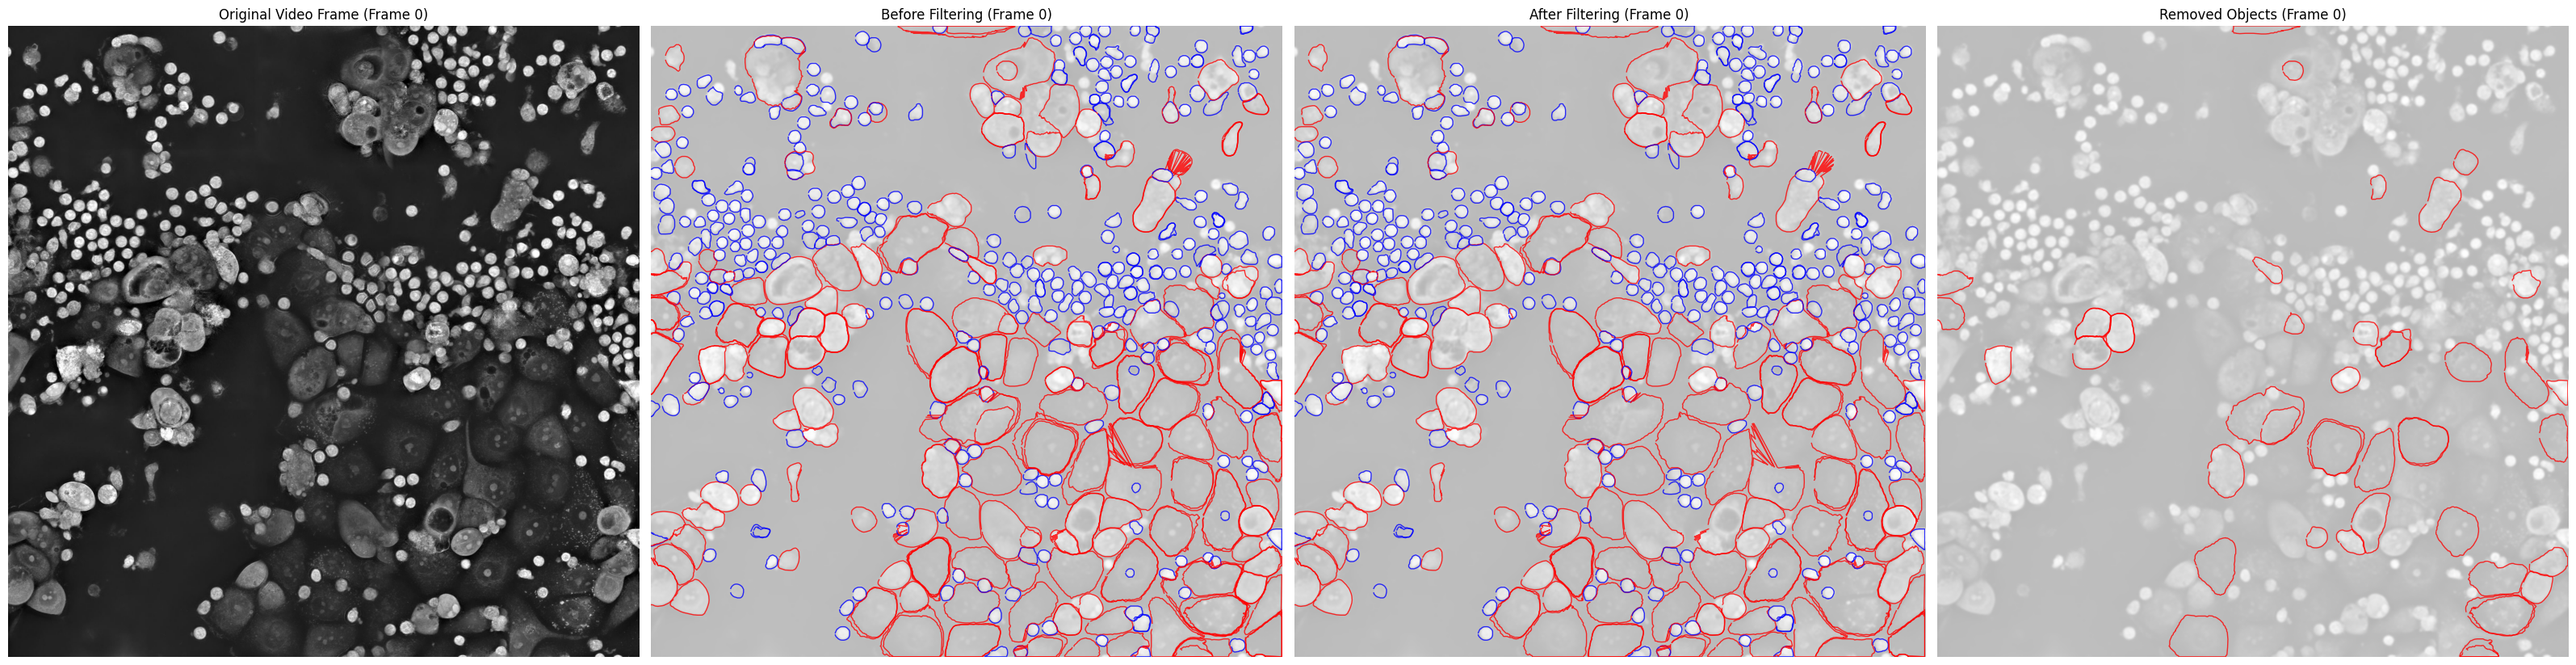


Success! Filtered data saved to: /home/adonyi/NanoLive/finetuned_results/positive/positive_finetuned_filtered.csv


In [3]:
csv_path = "/home/adonyi/NanoLive/finetuned_results/positive/positive_finetuned.csv"
video_path = "/home/adonyi/NanoLive/test_video.avi"
 
# Run the multi-frame processing
output_csv = create_multi_frame_filtered_csv(
     csv_path, 
     video_path, 
     size_ratio_threshold=0.9,  # Adjust based on your needs
     overlap_threshold=0.7      # Adjust based on your needs
 )
 
print(f"\nSuccess! Filtered data saved to: {output_csv}")

## QC

# quantified circum for all objects from frame (formate not the same, adjustment is needed)


In [1]:
import pandas as pd
import cupy as cp  # Use CuPy for GPU-accelerated computations
import numpy as np  # Added numpy for array operations

def load_and_process_frame(df, frame):
    """
    Load and process data for a specific frame.
    """
    df_frame = df[df['frame'] == frame]
    return df_frame

def find_closest_points_gpu(coords1, coords2, threshold):
    """
    Find pairs of points between coords1 and coords2 within the given threshold distance.
    This function uses CuPy for GPU acceleration.
    """
    coords1_gpu = cp.array(coords1)  # Move coords1 to GPU
    coords2_gpu = cp.array(coords2)  # Move coords2 to GPU
    
    interactions = []
    for point1 in coords1_gpu:
        distances = cp.linalg.norm(coords2_gpu - point1, axis=1)  # Compute distances in parallel
        close_points = cp.where(distances <= threshold)[0]  # Find indices of points within threshold
        for idx in close_points:
            interactions.append((tuple(point1.get()), tuple(coords2_gpu[idx].get())))  # Append to CPU memory
    
    return interactions

def calculate_segment_length(start, end):
    """
    Calculate the Euclidean distance between two points.
    """
    return cp.linalg.norm(cp.array(start) - cp.array(end)).get()  # Use CuPy and transfer result back to CPU

def calculate_metrics_for_frame(df_frame, interaction_threshold=3, proximity_threshold=5):
    """
    Calculate metrics for a single frame.
    """
    # Separate cells into "blue" and "red" groups
    blue_cells = df_frame[(df_frame['area'] >= 750) & (df_frame['area'] <= 2500)]
    red_cells = df_frame[(df_frame['area'] >= 3000) & (df_frame['area'] <= 50000)]
    
    total_red_length = 0
    total_green_length = 0
    total_orange_length = 0
    total_blue_length = 0  # New variable to track total blue length
    
    # Process each object
    for _, selected_object in df_frame.iterrows():
        selected_color = 'blue' if (selected_object['area'] >= 750 and selected_object['area'] <= 2500) else 'red'
        selected_coords = np.array(eval(selected_object['edge_coordinates']))  # Assuming edge_coordinates are stored as strings
        
        # Find all interactions involving the selected object
        interaction_edges = set()
        if selected_color == 'blue':
            other_group = red_cells
        else:
            other_group = blue_cells
        
        for _, other_row in other_group.iterrows():
            other_coords = np.array(eval(other_row['edge_coordinates']))
            interactions = find_closest_points_gpu(selected_coords, other_coords, interaction_threshold)
            if interactions:
                for point1, point2 in interactions:
                    interaction_edges.add(point1)
                    interaction_edges.add(point2)
        
        # Find proximity for red-red interactions if the selected object is red
        red_proximity_edges = set()
        if selected_color == 'red':
            red_coords_list = [np.array(eval(row['edge_coordinates'])) for _, row in red_cells.iterrows()]
            for red_coords in red_coords_list:
                if not np.array_equal(red_coords, selected_coords):  # Avoid comparing with itself
                    proximities = find_closest_points_gpu(selected_coords, red_coords, proximity_threshold)
                    if proximities:
                        for point in proximities:
                            red_proximity_edges.add(point[0])
        
        # Calculate total circumference and segment lengths
        total_circumference = 0
        green_length = 0
        orange_length = 0
        
        for i in range(len(selected_coords) - 1):
            segment_start = tuple(selected_coords[i])
            segment_end = tuple(selected_coords[i + 1])
            segment_length = calculate_segment_length(segment_start, segment_end)
            total_circumference += segment_length
            
            # Check if the segment is part of an interaction (green)
            if segment_start in interaction_edges or segment_end in interaction_edges:
                green_length += segment_length
            
            # Check if the segment is part of a proximity (orange) for red objects
            if selected_color == 'red' and (segment_start in red_proximity_edges or segment_end in red_proximity_edges):
                orange_length += segment_length
        
        # Calculate the red length (remaining part of the circumference)
        red_length = total_circumference - green_length - orange_length
        
        # Accumulate totals
        total_red_length += red_length
        total_green_length += green_length
        total_orange_length += orange_length
        
        # Accumulate total blue length if the object is blue
        if selected_color == 'blue':
            total_blue_length += total_circumference
    
    return total_red_length, total_green_length, total_orange_length, total_blue_length

def process_first_n_frames(csv_path, n_frames=5, interaction_threshold=3, proximity_threshold=5):
    """
    Process the first n frames and calculate metrics for each frame.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    
    results = []
    for frame in range(n_frames):  # Process only the first n frames
        df_frame = load_and_process_frame(df, frame)
        if not df_frame.empty:
            total_red, total_green, total_orange, total_blue = calculate_metrics_for_frame(
                df_frame, interaction_threshold, proximity_threshold
            )
            results.append({
                'frame': frame,
                'Total Red Length': total_red,
                'Total Green Length': total_green,
                'Total Orange Length': total_orange,
                'Total Blue Length': total_blue
            })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
csv_path = "/home/adonyi/NanoLive/finetuned_results/positive/positive_finetuned_filtered.csv"
results_df = process_first_n_frames(csv_path, n_frames=3, interaction_threshold=5, proximity_threshold=10)  #<-----------frames

# Save the results to a CSV file
output_csv_path = "first_5_frames_metrics.csv"
results_df.to_csv(output_csv_path, index=False)
print(f"Results for the first 5 frames saved to {output_csv_path}")


KeyboardInterrupt



## GPU optimization for that code (circum) specificaly WORKS WORKS WORKS

In [5]:
pip install cupy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import pandas as pd
import cupy as cp
import numpy as np
import time

In [11]:
import pandas as pd
import numpy as np
import time

# Attempt to import CuPy with graceful fallback
try:
    import cupy as cp
    GPU_AVAILABLE = True
except (ImportError, AttributeError):
    print("CuPy not available. Falling back to NumPy-only processing.")
    GPU_AVAILABLE = False
    cp = np

def check_gpu_info():
    """
    Check GPU information if CuPy is available
    """
    if not GPU_AVAILABLE:
        print("No GPU acceleration available.")
        return
    
    try:
        print(f"Number of CUDA devices: {cp.cuda.runtime.getDeviceCount()}")
        device = cp.cuda.runtime.getDevice()
        prop = cp.cuda.runtime.getDeviceProperties(device)
        print(f"Device Name: {prop['name'].decode()}")
        print(f"Total Memory: {prop['totalGlobalMem'] / (1024**3):.2f} GB")
        print(f"Multiprocessor Count: {prop['multiProcessorCount']}")
        print(f"Clock Rate: {prop['clockRate'] / 1000:.2f} MHz")
    except Exception as e:
        print(f"Error retrieving GPU info: {e}")

def optimize_gpu_memory():
    """
    Optimize GPU memory pool if CuPy is available
    """
    if not GPU_AVAILABLE:
        return
    
    try:
        mempool = cp.get_default_memory_pool()
        mempool.set_limit(size=40 * 1024 * 1024 * 1024)  # 40 GB pool
    except Exception as e:
        print(f"Error optimizing GPU memory: {e}")

def find_closest_points(coords1, coords2, threshold):
    """
    Find closest points with GPU or NumPy acceleration
    """
    if GPU_AVAILABLE:
        try:
            coords1_gpu = cp.array(coords1)
            coords2_gpu = cp.array(coords2)
            
            # Vectorized distance calculation
            diff = coords2_gpu[:, cp.newaxis] - coords1_gpu[cp.newaxis, :]
            distances = cp.linalg.norm(diff, axis=2)
            
            # Find interactions
            interactions = cp.where(distances <= threshold)
            
            return [(tuple(map(float, coord1)), tuple(map(float, coord2))) 
                    for coord1, coord2 in zip(
                        coords1_gpu[interactions[1]].get(), 
                        coords2_gpu[interactions[0]].get()
                    )]
        except Exception as e:
            print(f"GPU processing failed, falling back to NumPy: {e}")
    
    # NumPy fallback
    interactions = []
    for point1 in coords1:
        distances = np.linalg.norm(coords2 - point1, axis=1)
        close_points = np.where(distances <= threshold)[0]
        for idx in close_points:
            interactions.append((tuple(map(float, point1)), tuple(map(float, coords2[idx]))))
    
    return interactions

def calculate_segment_length(start, end):
    """
    Calculate Euclidean distance between two points
    """
    if GPU_AVAILABLE:
        try:
            return float(cp.linalg.norm(cp.array(start) - cp.array(end)).get())
        except Exception:
            pass
    
    return float(np.linalg.norm(np.array(start) - np.array(end)))

def calculate_metrics_for_frame(df_frame, interaction_threshold=3, proximity_threshold=5):
    """
    Calculate metrics for a single frame with GPU/NumPy processing
    """
    # Optimize memory if GPU is available
    optimize_gpu_memory()
    
    # Separate cells into "blue" and "red" groups
    blue_cells = df_frame[(df_frame['area'] >= 750) & (df_frame['area'] <= 2500)]
    red_cells = df_frame[(df_frame['area'] >= 3000) & (df_frame['area'] <= 50000)]
    
    total_red_length = 0
    total_green_length = 0
    total_orange_length = 0
    total_blue_length = 0
    
    # Process each object
    for _, selected_object in df_frame.iterrows():
        selected_color = 'blue' if (selected_object['area'] >= 750 and selected_object['area'] <= 2500) else 'red'
        selected_coords = np.array(eval(selected_object['edge_coordinates']))
        
        # Batch interaction detection
        interaction_edges = set()
        red_proximity_edges = set()
        
        if selected_color == 'blue':
            other_group = red_cells
            other_coords_list = [np.array(eval(row['edge_coordinates'])) for _, row in other_group.iterrows()]
            if other_coords_list:
                interactions_batch = find_closest_points(selected_coords, 
                                                        np.vstack(other_coords_list), 
                                                        interaction_threshold)
                for point1, point2 in interactions_batch:
                    interaction_edges.add(point1)
                    interaction_edges.add(point2)
        else:
            # Red proximity detection
            red_coords_list = [np.array(eval(row['edge_coordinates'])) for _, row in red_cells.iterrows()]
            red_coords_list = [coords for coords in red_coords_list if not np.array_equal(coords, selected_coords)]
            
            if red_coords_list:
                proximity_batch = find_closest_points(selected_coords, 
                                                      np.vstack(red_coords_list), 
                                                      proximity_threshold)
                red_proximity_edges = {point[0] for point in proximity_batch}
        
        # Calculate circumference and segment lengths
        total_circumference = 0
        green_length = 0
        orange_length = 0
        
        for i in range(len(selected_coords) - 1):
            segment_start = tuple(map(float, selected_coords[i]))
            segment_end = tuple(map(float, selected_coords[i + 1]))
            segment_length = calculate_segment_length(segment_start, segment_end)
            total_circumference += segment_length
            
            # Check segment interactions
            if segment_start in interaction_edges or segment_end in interaction_edges:
                green_length += segment_length
            
            # Check red proximity for red objects
            if selected_color == 'red' and (segment_start in red_proximity_edges or segment_end in red_proximity_edges):
                orange_length += segment_length
        
        # Calculate red length
        red_length = total_circumference - green_length - orange_length
        
        # Accumulate totals
        total_red_length += red_length
        total_green_length += green_length
        total_orange_length += orange_length
        
        # Accumulate total blue length if the object is blue
        if selected_color == 'blue':
            total_blue_length += total_circumference
    
    return total_red_length, total_green_length, total_orange_length, total_blue_length

def process_first_n_frames(csv_path, n_frames=5, interaction_threshold=3, proximity_threshold=5):
    """
    Process the first n frames and calculate metrics with performance tracking
    """
    # Check GPU information before processing
    check_gpu_info()
    
    # Load the CSV file
    df = pd.read_csv(csv_path)
    
    results = []
    total_processing_time = 0
    
    for frame in range(n_frames):
        start_time = time.time()
        
        df_frame = df[df['frame'] == frame]
        if not df_frame.empty:
            total_red, total_green, total_orange, total_blue = calculate_metrics_for_frame(
                df_frame, interaction_threshold, proximity_threshold
            )
            
            frame_processing_time = time.time() - start_time
            total_processing_time += frame_processing_time
            
            results.append({
                'frame': frame,
                'Total Red Length': total_red,
                'Total Green Length': total_green,
                'Total Orange Length': total_orange,
                'Total Blue Length': total_blue,
                'Frame Processing Time (s)': frame_processing_time
            })
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    print(f"Total Processing Time for {n_frames} frames: {total_processing_time:.4f} seconds")
    print(f"Average Frame Processing Time: {total_processing_time/n_frames:.4f} seconds")
    
    return results_df

# Example usage
csv_path = "/home/adonyi/NanoLive/finetuned_results/negative/negative_finetuned_filtered.csv"
results_df = process_first_n_frames(csv_path, n_frames=100, interaction_threshold=5, proximity_threshold=10)

# Save the results to a CSV file
output_csv_path = "first_100_frames_metrics_negative.csv"
results_df.to_csv(output_csv_path, index=False)
print(f"Results for the first 5 frames saved to {output_csv_path}")

Number of CUDA devices: 1
Device Name: NVIDIA RTX 6000 Ada Generation
Total Memory: 47.40 GB
Multiprocessor Count: 142
Clock Rate: 2505.00 MHz
Total Processing Time for 100 frames: 1300.0263 seconds
Average Frame Processing Time: 13.0003 seconds
Results for the first 5 frames saved to first_100_frames_metrics_negative.csv


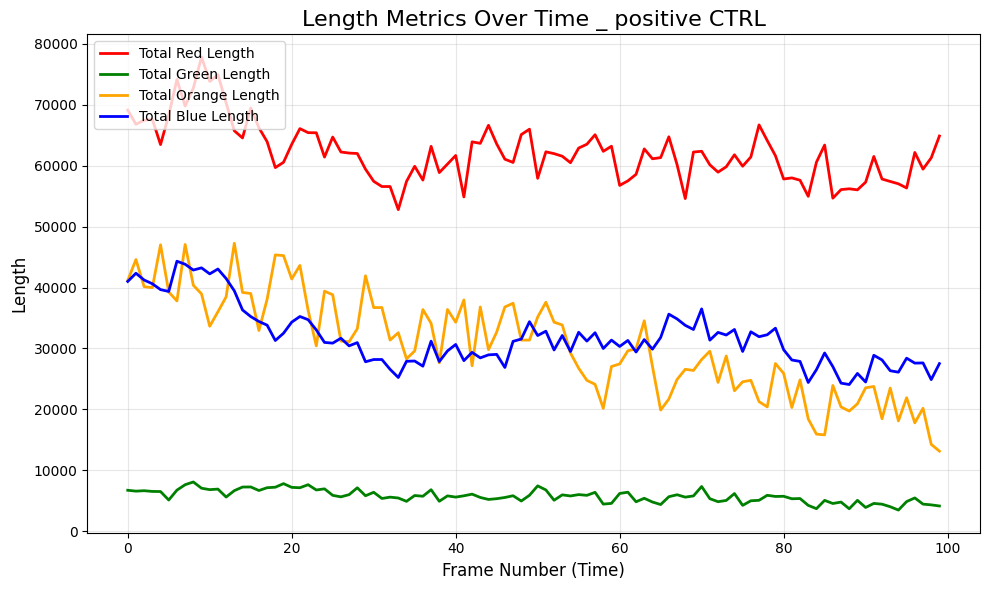

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = '/home/adonyi/NanoLive/finetuned_results/positive/first_100_frames_metrics_positive.csv'
data = pd.read_csv(file_path)

# Step 2: Extract relevant columns
columns_to_plot = ['Total Red Length', 'Total Green Length', 'Total Orange Length', 'Total Blue Length']
x = data['frame']  # Frame numbers as x-axis (time)

# Step 3: Define colors for each column
colors = {
    'Total Red Length': 'red',
    'Total Green Length': 'green',
    'Total Orange Length': 'orange',
    'Total Blue Length': 'blue'
}

# Step 4: Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size

for column in columns_to_plot:
    plt.plot(x, data[column], label=column, color=colors[column], linewidth=2)

# Step 5: Customize the plot
plt.title('Length Metrics Over Time _ positive CTRL', fontsize=16)
plt.xlabel('Frame Number (Time)', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.legend(loc='upper left', fontsize=10)  # Add a legend
plt.grid(alpha=0.3)  # Add a light grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

In [20]:
data.columns

Index(['frame', 'Total Red Length', 'Total Green Length',
       'Total Orange Length', 'Total Blue Length',
       'Frame Processing Time (s)'],
      dtype='object')

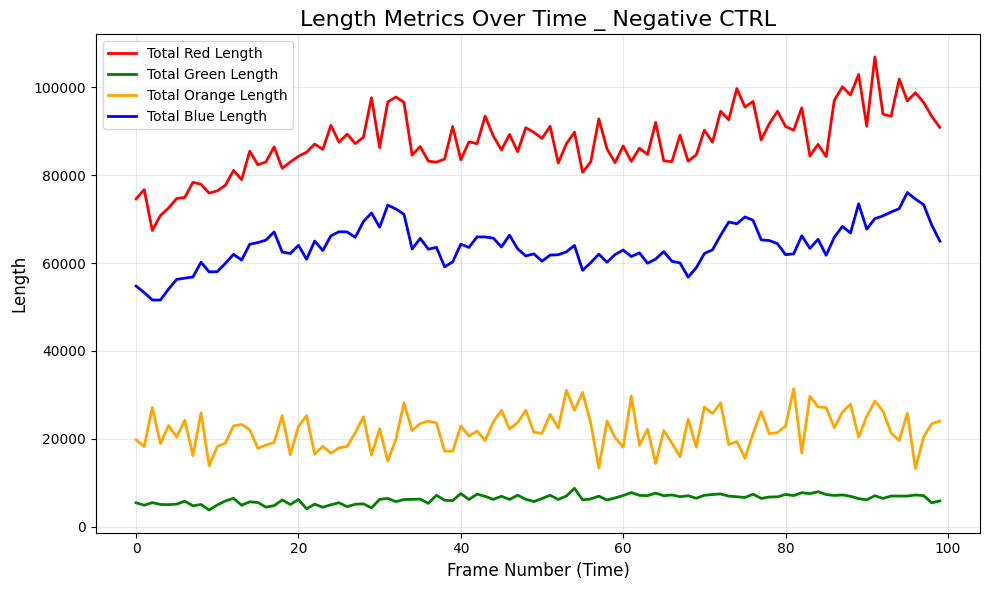

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the data
file_path = '/home/adonyi/NanoLive/finetuned_results/negative/first_100_frames_metrics_negative.csv'
data = pd.read_csv(file_path)

# Step 2: Extract relevant columns
columns_to_plot = ['Total Red Length', 'Total Green Length', 'Total Orange Length', 'Total Blue Length']
x = data['frame']  # Frame numbers as x-axis (time)

# Step 3: Define colors for each column
colors = {
    'Total Red Length': 'red',
    'Total Green Length': 'green',
    'Total Orange Length': 'orange',
    'Total Blue Length': 'blue'
}

# Step 4: Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size

for column in columns_to_plot:
    plt.plot(x, data[column], label=column, color=colors[column], linewidth=2)

# Step 5: Customize the plot
plt.title('Length Metrics Over Time _ Negative CTRL', fontsize=16)
plt.xlabel('Frame Number (Time)', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.legend(loc='upper left', fontsize=10)  # Add a legend
plt.grid(alpha=0.3)  # Add a light grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()

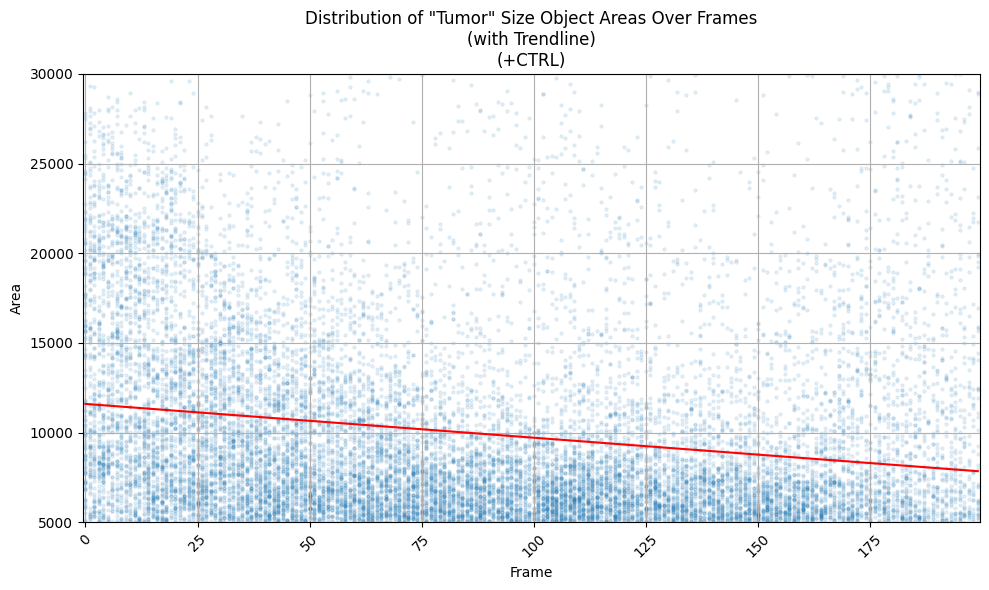

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("/home/adonyi/NanoLive/finetuned_results/positive/positive_finetuned_filtered.csv")

min_area = 5000  # Adjust
max_area = 30000  # Adjust

# Filter objects based on the area range
df = df[(df['area'] >= min_area) & (df['area'] <= max_area)]

# Create a scatter plot with smaller dots and extended x-axis
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.scatter(df['frame'], df['area'], s=5, alpha=0.1)  # Reduce dot size and add transparency

# Set y-axis limits based on your data (adjust as needed)
plt.ylim(5000, 30000)

# Extend x-axis limits for better separation (adjust based on your data range)
plt.xlim(df['frame'].min() - 0.5, df['frame'].max() + 0.5)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Area')
title = 'Distribution of "Tumor" Size Object Areas Over Frames\n(with Trendline)\n(+CTRL)'
plt.title(title)

# Rotate x-axis labels for better readability if there are many frames
plt.xticks(rotation=45)

# Fit a linear trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(df['frame'], df['area'])
line_x = range(df['frame'].min(), df['frame'].max() + 1)
line_y = slope * line_x + intercept

# Add the trendline to the plot
plt.plot(line_x, line_y, color='red')

# Show the plot
plt.grid(True)  # Add gridlines for better visual reference
plt.tight_layout()  # Adjust spacing between elements for a cleaner look
plt.show()

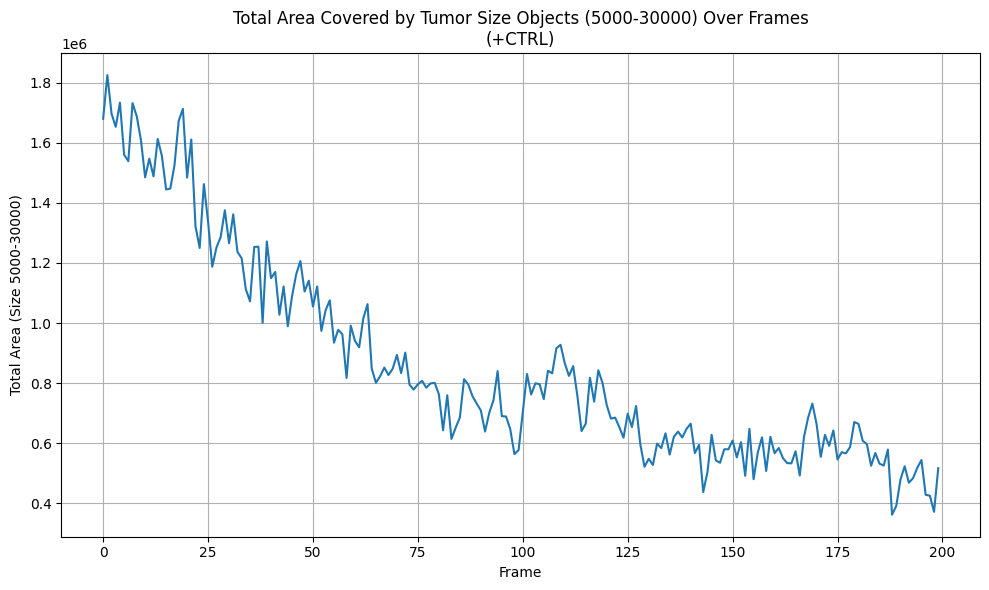

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/home/adonyi/NanoLive/finetuned_results/positive/positive_finetuned_filtered.csv")

min_area = 5000  # Adjust
max_area = 30000  # Adjust

# Filter objects based on the area range
filtered_df = df[(df['area'] >= min_area) & (df['area'] <= max_area)]

# Group by frame and calculate total area
total_area_per_frame = filtered_df.groupby('frame')['area'].sum()

# Create a line plot to visualize total area over time
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.plot(total_area_per_frame.index, total_area_per_frame.values)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Total Area (Size 5000-30000)')
title = 'Total Area Covered by Tumor Size Objects (5000-30000) Over Frames\n(+CTRL)'
plt.title(title)

# Add gridlines for better visual reference
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust spacing between elements for a cleaner look
plt.show()

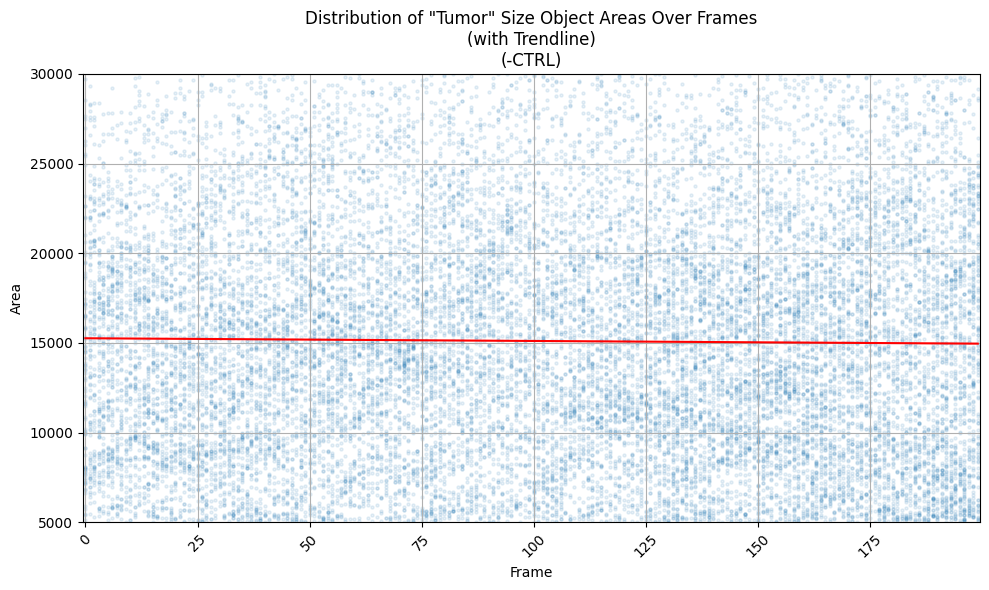

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("/home/adonyi/NanoLive/finetuned_results/negative/negative_finetuned.csv")

min_area = 5000  # Adjust
max_area = 30000  # Adjust

# Filter objects based on the area range
df = df[(df['area'] >= min_area) & (df['area'] <= max_area)]

# Create a scatter plot with smaller dots and extended x-axis
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.scatter(df['frame'], df['area'], s=5, alpha=0.1)  # Reduce dot size and add transparency

# Set y-axis limits based on your data (adjust as needed)
plt.ylim(5000, 30000)

# Extend x-axis limits for better separation (adjust based on your data range)
plt.xlim(df['frame'].min() - 0.5, df['frame'].max() + 0.5)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Area')
title = 'Distribution of "Tumor" Size Object Areas Over Frames\n(with Trendline)\n(-CTRL)'
plt.title(title)

# Rotate x-axis labels for better readability if there are many frames
plt.xticks(rotation=45)

# Fit a linear trendline
slope, intercept, r_value, p_value, std_err = stats.linregress(df['frame'], df['area'])
line_x = range(df['frame'].min(), df['frame'].max() + 1)
line_y = slope * line_x + intercept

# Add the trendline to the plot
plt.plot(line_x, line_y, color='red')

# Show the plot
plt.grid(True)  # Add gridlines for better visual reference
plt.tight_layout()  # Adjust spacing between elements for a cleaner look
plt.show()

# metrics

In [26]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/home/adonyi/NanoLive/finetuned_results/positive/first_100_frames_metrics_positive.csv'
df = pd.read_csv(file_path)

# Define the calculations for each metric
def calculate_iei(row):
    red_length = row['Total Red Length']
    green_length = row['Total Green Length']
    blue_length = row['Total Blue Length']
    orange_length = row['Total Orange Length']
    
    total_perimeter = red_length + blue_length + orange_length
    orange_ratio = orange_length / total_perimeter if total_perimeter > 0 else 0
    denominator = red_length + blue_length
    ie_i = (green_length / denominator) * (1 - orange_ratio) if denominator > 0 else 0
    return ie_i

def calculate_ier(row):
    green_length = row['Total Green Length']
    blue_length = row['Total Blue Length']
    ier = green_length / blue_length if blue_length > 0 else 0
    return ier

def calculate_ter(row):
    green_length = row['Total Green Length']
    red_length = row['Total Red Length']
    ter = green_length / red_length if red_length > 0 else 0
    return ter

def calculate_iir(row):
    orange_length = row['Total Orange Length']
    red_length = row['Total Red Length']
    denominator = red_length + orange_length
    iir = orange_length / denominator if denominator > 0 else 0
    return iir

# Apply the calculations to each row
df['Interaction Efficiency Index (IEI)'] = df.apply(calculate_iei, axis=1)
df['Immune Engagement Ratio (IER)'] = df.apply(calculate_ier, axis=1)
df['Tumor Exposure Ratio (TER)'] = df.apply(calculate_ter, axis=1)
df['Interaction Inhibition Ratio (IIR)'] = df.apply(calculate_iir, axis=1)

# Save the updated DataFrame to a new CSV file
output_file_path = '/home/adonyi/NanoLive/finetuned_results/positive/first_100_frames_metrics_with_calculations.csv'
df.to_csv(output_file_path, index=False)

print(f"Updated file saved to: {output_file_path}")
df.to_csv(output_file_path, index=False)

print(f"Updated file saved to: {output_file_path}")

SyntaxError: invalid syntax (177043295.py, line 49)

In [22]:
cal = pd.read_csv("/home/adonyi/NanoLive/finetuned_results/positive/first_100_frames_metrics_with_calculations.csv")
cal

frame  Total Red Length  Total Green Length  Total Orange Length  \
0       0       69124.34139         6720.747833          41160.64616   
1       1       66801.77289         6578.425950          44593.79427   
2       2       67464.86415         6647.387794          40139.44068   
3       3       67619.82141         6531.646047          39974.14991   
4       4       63473.93292         6512.456826          47019.89498   
..    ...               ...                 ...                  ...   
95     95       56341.62134         4867.416722          21913.62629   
96     96       62176.27043         5462.922879          17785.60347   
97     97       59438.18485         4446.799134          20178.84574   
98     98       61288.57127         4325.345886          14258.19671   
99     99       64875.37013         4140.999622          13142.46935   

    Total Blue Length  Frame Processing Time (s)  \
0         41001.67517                  15.264238   
1         42345.80547                  16.538522   
2         41232.45322                  15.035632   
3         40623.66292                  15.552588   
4         39659.76468                  16.347450   
..                ...                        ...   
95        28407.18561                   8.885667   
96        27592.81953                   9.376977   
97        27625.24585                   8.845970   
98        24885.08034                   7.718962   
99        27515.44288                   7.894687   

    Interaction Efficiency Index (IEI)  Immune Engagement Ratio (IER)  \
0                             0.044424                       0.163914   
1                             0.042789                       0.155350   
2                             0.044662                       0.161217   
3                             0.044068                       0.160784   
4                             0.043372                       0.164208   
..                                 ...                            ...   
95                            0.045634                       0.171345   
96                            0.050792                       0.197983   
97                            0.041465                       0.160969   
98                            0.043067                       0.173813   
99                            0.039239                       0.150497   

    Tumor Exposure Ratio (TER)  Interaction Inhibition Ratio (IIR)  
0                     0.097227                            0.373221  
1                     0.098477                            0.400319  
2                     0.098531                            0.373028  
3                     0.096594                            0.371528  
4                     0.102600                            0.425543  
..                         ...                                 ...  
95                    0.086391                            0.280028  
96                    0.087862                            0.222426  
97                    0.074814                            0.253449  
98                    0.070573                            0.188733  
99                    0.063830                            0.168455  

[100 rows x 10 columns]

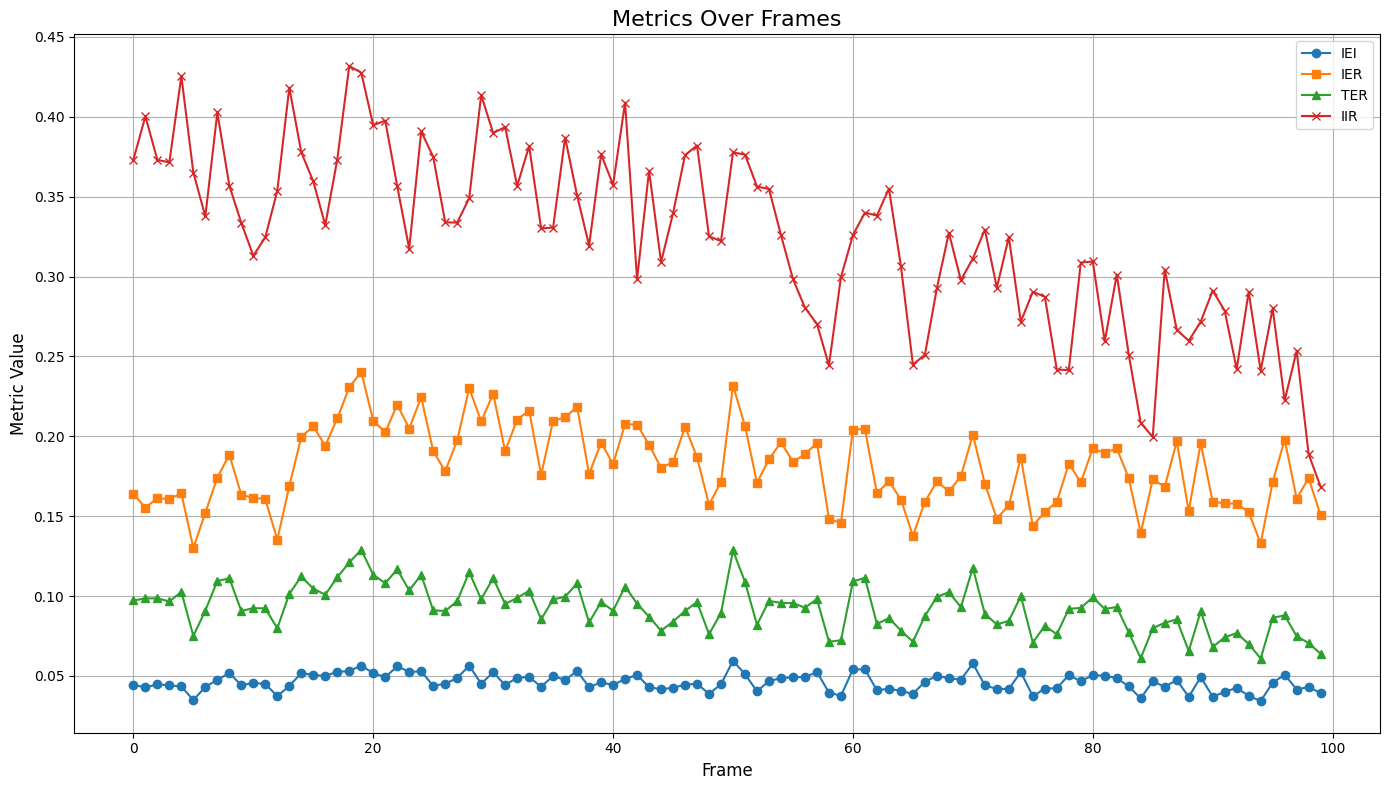

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated CSV file with calculated metrics
file_path = '/home/adonyi/NanoLive/finetuned_results/positive/first_100_frames_metrics_with_calculations.csv'
cal = pd.read_csv(file_path)

# Ensure 'frame' column exists and is numeric
cal['frame'] = cal['frame'].astype(int)

# Create a line chart for each metric
plt.figure(figsize=(14, 8))

# Plot Interaction Efficiency Index (IEI)
plt.plot(cal['frame'], cal['Interaction Efficiency Index (IEI)'], label='IEI', marker='o')

# Plot Immune Engagement Ratio (IER)
plt.plot(cal['frame'], cal['Immune Engagement Ratio (IER)'], label='IER', marker='s')

# Plot Tumor Exposure Ratio (TER)
plt.plot(cal['frame'], cal['Tumor Exposure Ratio (TER)'], label='TER', marker='^')

# Plot Interaction Inhibition Ratio (IIR)
plt.plot(cal['frame'], cal['Interaction Inhibition Ratio (IIR)'], label='IIR', marker='x')

# Add labels, title, and legend
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Metrics Over Frames', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/home/adonyi/NanoLive/finetuned_results/negative/first_100_frames_metrics_negative.csv'
df = pd.read_csv(file_path)

# Define the calculations for each metric
def calculate_iei(row):
    red_length = row['Total Red Length']
    green_length = row['Total Green Length']
    blue_length = row['Total Blue Length']
    orange_length = row['Total Orange Length']
    
    total_perimeter = red_length + blue_length + orange_length
    orange_ratio = orange_length / total_perimeter if total_perimeter > 0 else 0
    denominator = red_length + blue_length
    ie_i = (green_length / denominator) * (1 - orange_ratio) if denominator > 0 else 0
    return ie_i

def calculate_ier(row):
    green_length = row['Total Green Length']
    blue_length = row['Total Blue Length']
    ier = green_length / blue_length if blue_length > 0 else 0
    return ier

def calculate_ter(row):
    green_length = row['Total Green Length']
    red_length = row['Total Red Length']
    ter = green_length / red_length if red_length > 0 else 0
    return ter

def calculate_iir(row):
    orange_length = row['Total Orange Length']
    red_length = row['Total Red Length']
    denominator = red_length + orange_length
    iir = orange_length / denominator if denominator > 0 else 0
    return iir

# Apply the calculations to each row
df['Interaction Efficiency Index (IEI)'] = df.apply(calculate_iei, axis=1)
df['Immune Engagement Ratio (IER)'] = df.apply(calculate_ier, axis=1)
df['Tumor Exposure Ratio (TER)'] = df.apply(calculate_ter, axis=1)
df['Interaction Inhibition Ratio (IIR)'] = df.apply(calculate_iir, axis=1)

# Save the updated DataFrame to a new CSV file
output_file_path = '/home/adonyi/NanoLive/finetuned_results/negative/first_100_frames_metrics_with_calculations.csv'
df.to_csv(output_file_path, index=False)

print(f"Updated file saved to: {output_file_path}")

Updated file saved to: /home/adonyi/NanoLive/finetuned_results/negative/first_100_frames_metrics_with_calculations.csv


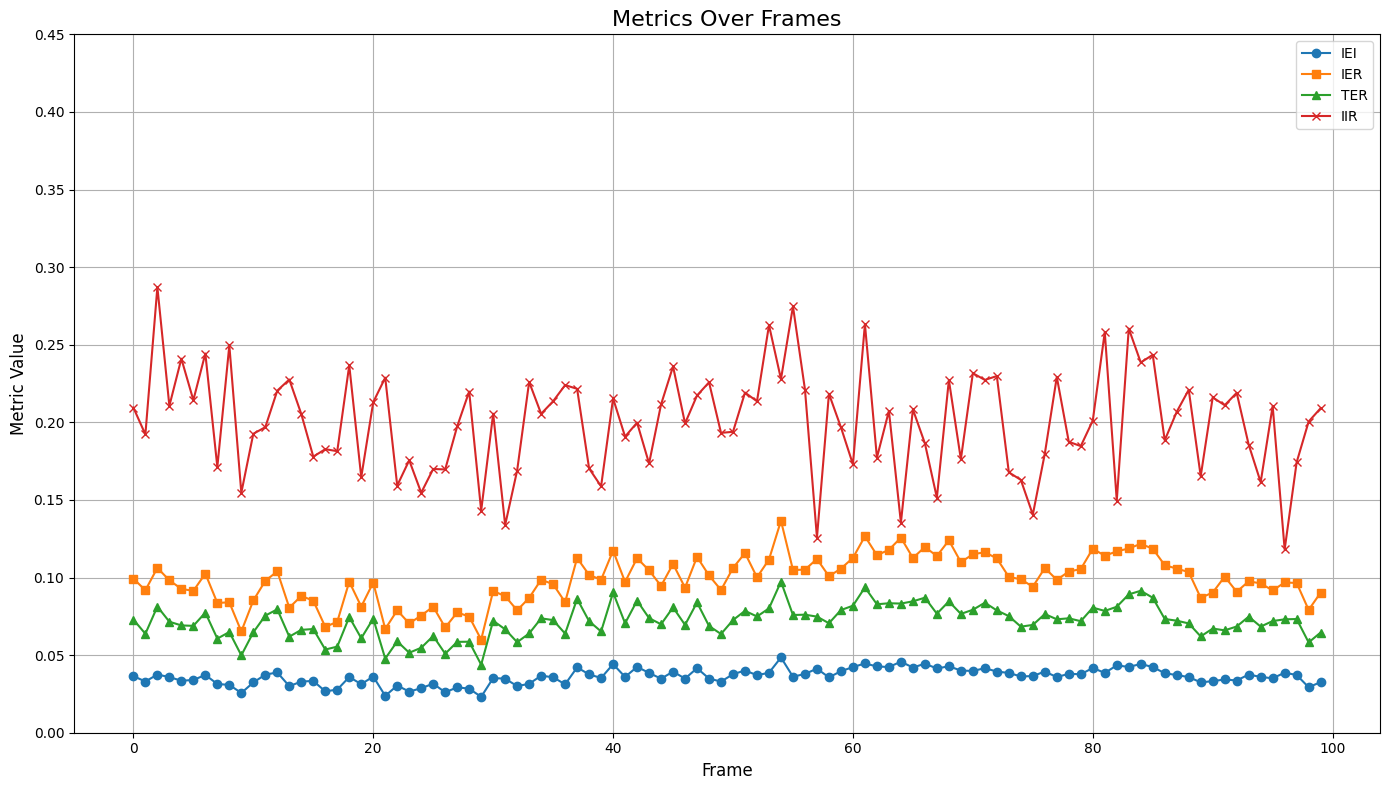

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the updated CSV file with calculated metrics
file_path = '/home/adonyi/NanoLive/finetuned_results/negative/first_100_frames_metrics_with_calculations.csv'
cal = pd.read_csv(file_path)

# Ensure 'frame' column exists and is numeric
cal['frame'] = cal['frame'].astype(int)

# Create a line chart for each metric
plt.figure(figsize=(14, 8))

# Plot Interaction Efficiency Index (IEI)
plt.plot(cal['frame'], cal['Interaction Efficiency Index (IEI)'], label='IEI', marker='o')

# Plot Immune Engagement Ratio (IER)
plt.plot(cal['frame'], cal['Immune Engagement Ratio (IER)'], label='IER', marker='s')

# Plot Tumor Exposure Ratio (TER)
plt.plot(cal['frame'], cal['Tumor Exposure Ratio (TER)'], label='TER', marker='^')

# Plot Interaction Inhibition Ratio (IIR)
plt.plot(cal['frame'], cal['Interaction Inhibition Ratio (IIR)'], label='IIR', marker='x')

# Add labels, title, and legend
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.title('Metrics Over Frames', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)

# Set y-axis range from 0 to 0.45 with ticks every 0.05
plt.ylim(0, 0.45)
plt.yticks(np.arange(0, 0.5, 0.05))

# Show the plot
plt.tight_layout()
plt.show()